#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [72]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

%matplotlib inline

sns.set(style="darkgrid")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [40]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    w = np.array(w)
    logits = np.dot(X, w) + w0
    margins = y * logits
    logistic_loss = np.mean(np.logaddexp(0, -margins))
    l1_penalty = gamma * np.linalg.norm(w, ord=1)
    l2_penalty = beta * np.square(np.linalg.norm(w, ord=2))
    return logistic_loss + l1_penalty + l2_penalty

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [11]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    w_np = np.array(w)
    linear = X @ w_np + w0
    z = y * linear
    sigmoid = 1 / (1 + np.exp(z))
    grad_w = (-1 / X.shape[0]) * (X.T @ (y * sigmoid)) + gamma * np.sign(w_np) + 2 * beta * w_np
    grad_w0 = (-1 / X.shape[0]) * np.sum(y * sigmoid)
    return grad_w.tolist(), grad_w0

In [18]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [50]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []


    def fit(self, X, y):
        np.random.seed(self.random_state)
        X_np = np.array(X)
        y_np = np.array(y)
        N, K = X_np.shape
        self.w = np.zeros(K)
        self.w0 = 0.0
        prev_loss = float('inf')
        self.loss_history = []
        for iteration in range(self.max_iter):
            gradients = get_grad(X_np, y_np, self.w.tolist(), self.w0, self.gamma, self.beta)
            grad_w = np.array(gradients[0])
            grad_w0 = gradients[1]
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0
            current_loss = loss(X_np, y_np, self.w.tolist(), self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)
            if abs(prev_loss - current_loss) < self.tolerance:
                print(f"Сходимость достигнута на итерации {iteration+1}")
                break
            prev_loss = current_loss
        return self


    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        X_np = np.array(X)
        linear = np.dot(X_np, self.w) + self.w0
        probs = 1 / (1 + np.exp(-linear))
        return np.vstack([1 - probs, probs]).T


    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        probs = self.predict_proba(X)[:, 1]
        predictions = np.where(probs >= 0.5, 1, -1)
        return predictions.tolist()

In [21]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [68]:
def plot_decision_boundary(model, X, y):
    X_np, y_np = np.array(X), np.array(y)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(
        X_np[y_np == 1, 0],
        X_np[y_np == 1, 1],
        color='red',
        marker='o',
        label='Класс 1',
        edgecolor='k',
        s=100,
        alpha=0.7
    )
    ax.scatter(
        X_np[y_np == -1, 0],
        X_np[y_np == -1, 1],
        color='blue',
        marker='x',
        label='Класс -1',
        edgecolor='k',
        s=100,
        alpha=0.7
    )
    w, w0 = model.w, model.w0
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    x_values = np.linspace(x_min, x_max, 666)
    y_values = np.where(
        w[1] != 0,
        (-w0 - w[0] * x_values) / w[1],
        np.full_like(x_values, -w0 / w[0])
    )
    ax.plot(x_values, y_values, color='yellow', linewidth=2, label='Граница решения')
    ax.grid(True)
    plt.show()

<ipython-input-68-243911d3a2e3>:16: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


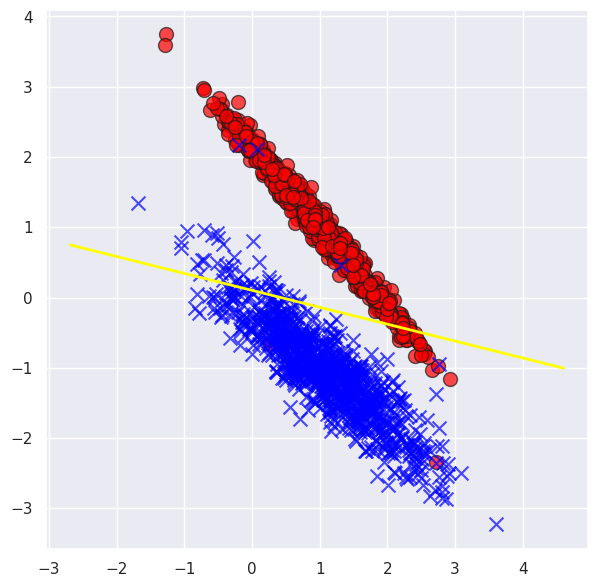

In [69]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [70]:
def plot_loss_history(model):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(model.loss_history) + 1), model.loss_history, marker='o', linestyle='-')
    plt.xlabel('Итерация')
    plt.ylabel('Значение функции потерь')
    plt.title('История функции потерь при обучении')
    plt.grid(True)
    plt.show

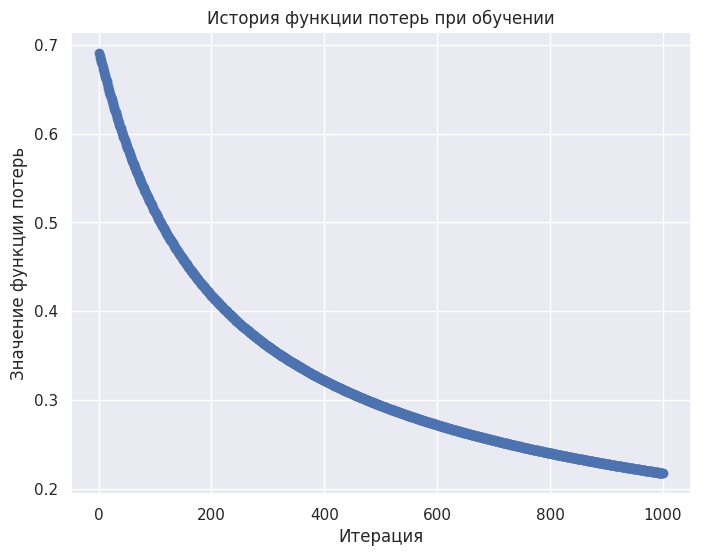

In [71]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [81]:
def split_data(X, y, test_size=0.3, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

In [87]:
def evaluate_svc(X_train, y_train, X_test, y_test, kernels, C_values):
    results = []
    for kernel in kernels:
        for C in C_values:
            clf = SVC(kernel=kernel, C=C, probability=True, random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_proba = clf.predict_proba(X_test)[:, 1]

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)

            results.append({
                'Kernel': kernel,
                'C': C,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'AUC-ROC': auc,
                'F1-Score': f1
            })
    return pd.DataFrame(results)

In [99]:
def plot_metrics(df):
    metrics = ['Accuracy', 'Precision', 'Recall', 'AUC-ROC', 'F1-Score']
    plt.figure(figsize=(20, 20))
    for idx, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, idx)
        sns.lineplot(data=df, x='C', y=metric, hue='Kernel', marker='o')
        plt.xscale('log')
        plt.title(metric)
        plt.xlabel('C')
        plt.grid(True)
    plt.show()


,Kernel,C,Accuracy,Precision,Recall,AUC-ROC,F1-Score
0,linear,0.1,0.992593,0.988971,0.996296,0.995446,0.992620
1,linear,1.0,0.992593,0.988971,0.996296,0.995501,0.992620
2,linear,10.0,0.992593,0.988971,0.996296,0.995926,0.992620
3,linear,100.0,0.992593,0.988971,0.996296,0.996022,0.992620
4,poly,0.1,0.994444,0.992620,0.996296,0.992833,0.994455
5,poly,1.0,0.994444,0.992620,0.996296,0.993745,0.994455
6,poly,10.0,0.994444,0.992620,0.996296,0.994047,0.994455
7,poly,100.0,0.994444,0.992620,0.996296,0.994047,0.994455
8,rbf,0.1,0.994444,0.992620,0.996296,0.997394,0.994455
9,rbf,1.0,0.994444,0.992620,0.996296,0.997791,0.994455


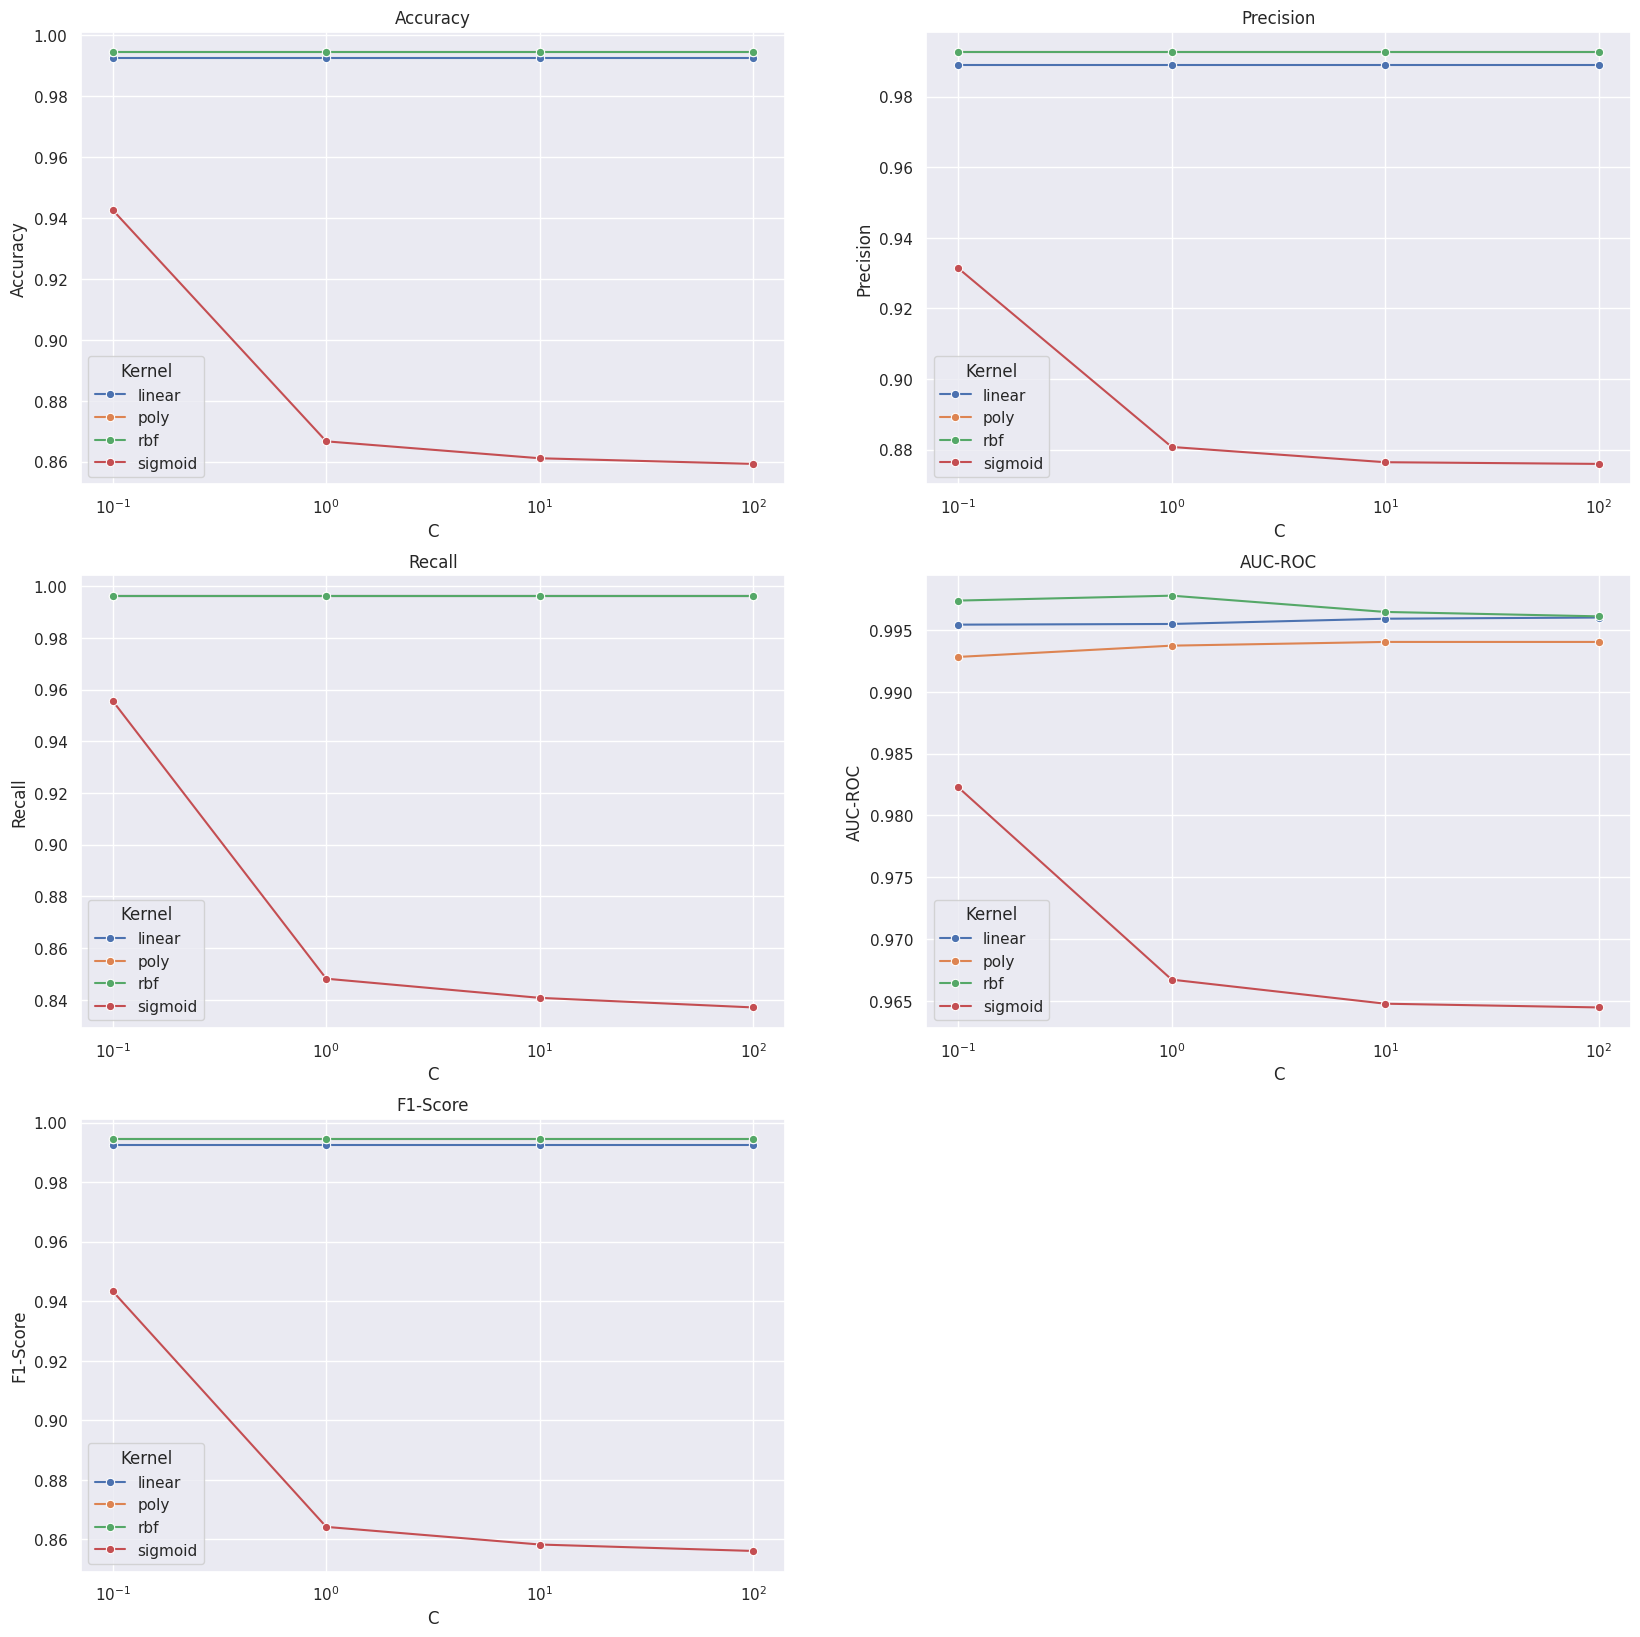

In [100]:
X_train, X_test, y_train, y_test = split_data(X, y)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100]
results_df = evaluate_svc(X_train, y_train, X_test, y_test, kernels, C_values)
display(results_df)
plot_metrics(results_df)

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [117]:
from collections import Counter

class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _compute_distances(self, X):
        if self.metric == 'euclidean':
            return np.sqrt(((X[:, np.newaxis] - self.X_train) ** 2).sum(axis=2))
        elif self.metric == 'manhattan':
            return np.abs(X[:, np.newaxis] - self.X_train).sum(axis=2)

    def predict(self, X):
        distances = self._compute_distances(X)
        neighbors_idx = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        neighbors_labels = self.y_train[neighbors_idx]
        return np.array([Counter(row).most_common(1)[0][0] for row in neighbors_labels])

    def predict_proba(self, X):
        distances = self._compute_distances(X)
        neighbors_idx = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        neighbors_labels = self.y_train[neighbors_idx]
        classes = np.unique(self.y_train)
        neighbors_labels = np.where(neighbors_labels == -1, 0, neighbors_labels)
        probas = np.array([
            np.bincount(row, minlength=classes.max()+1)[classes] / self.n_neighbors
            for row in neighbors_labels
        ])
        return probas


In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
k_values = [3, 5, 7]
metrics_list = []
for k in k_values:
    knn = KNNClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_proba = knn.predict_proba(X_test)
    metrics = {
        'K': k,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=1),
        'Recall': recall_score(y_test, y_pred, pos_label=1),
        'AUC-ROC': roc_auc_score(y_test, y_proba[:,1]),
        'F1-Score': f1_score(y_test, y_pred, pos_label=1)
    }
    metrics_list.append(metrics)
results_df = pd.DataFrame(metrics_list)
results_df.head()


,K,Accuracy,Precision,Recall,AUC-ROC,F1-Score
0,3,0.992593,0.988971,0.996296,0.994369,0.992620
1,5,0.992593,0.988971,0.996296,0.994376,0.992620
2,7,0.994444,0.992620,0.996296,0.994348,0.994455


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [121]:
df = pd.read_csv("/content/drive/MyDrive/hse/ml/train.csv")

In [127]:
df[:2]

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
train_df = df.iloc[:50000].reset_index(drop=True)
test_df = df.iloc[50000:].reset_index(drop=True)

In [129]:
train_df.head()

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
test_df.head()

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,50000,6,0,0,0,0,0,0,0,0,...,2,0,0,103,132,9,0,0,0,0
1,50001,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,50002,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50003,4,0,0,0,0,0,0,0,0,...,0,1,0,0,139,96,59,0,0,0
4,50004,2,0,0,0,0,0,0,0,0,...,0,0,0,106,47,69,23,0,0,0


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

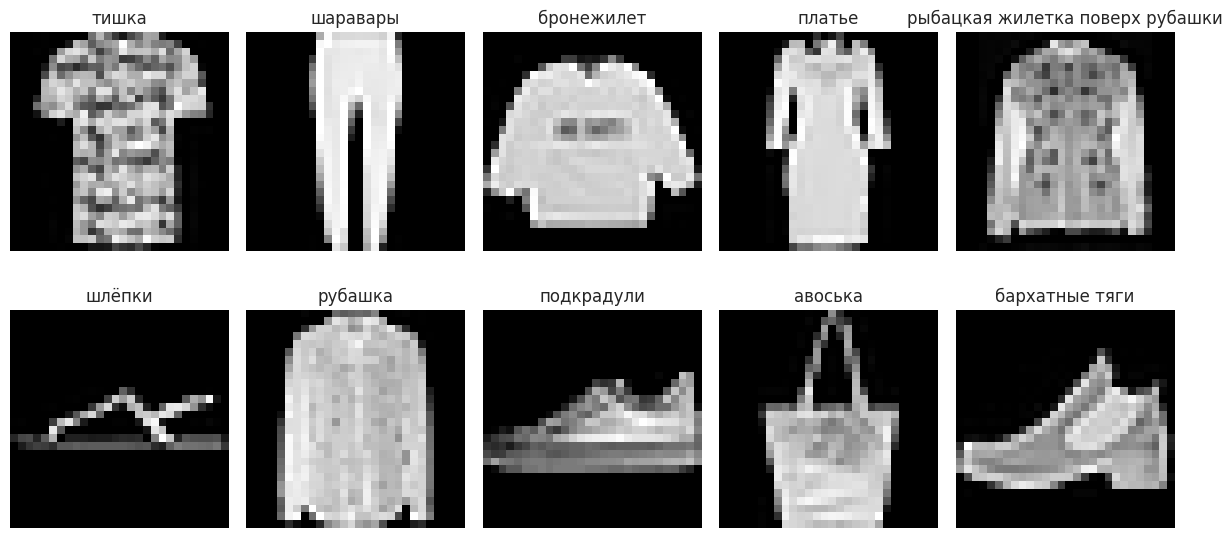

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

category_names = {
    0: 'тишка',
    1: 'шаравары',
    2: 'бронежилет',
    3: 'платье',
    4: 'рыбацкая жилетка поверх рубашки',
    5: 'шлёпки',
    6: 'рубашка',
    7: 'подкрадули',
    8: 'авоська',
    9: 'бархатные тяги'
}

samples = train_df.groupby('Category').first().reset_index()
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for idx, (_, row) in enumerate(samples.iterrows()):
    pixels = row[[f'Pixel{i:03}' for i in range(784)]].values.reshape(28, 28)

    axes[idx].imshow(pixels, cmap='gray')
    axes[idx].set_title(category_names[row['Category']])
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [136]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [135]:
feature_cols = [f'Pixel{i:03}' for i in range(784)]
X_train = train_df[feature_cols].values
X_test = test_df[feature_cols].values
y_train = train_df['Category'].values
y_test = test_df['Category'].values

In [137]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_train_standard = standard_scaler.fit_transform(X_train)
X_train_minmax = minmax_scaler.fit_transform(X_train)

X_test_standard = standard_scaler.transform(X_test)
X_test_minmax = minmax_scaler.transform(X_test)


In [138]:
train_standard_df = pd.DataFrame(X_train_standard, columns=feature_cols)
train_standard_df.insert(0, 'Category', y_train)
train_standard_df.insert(0, 'Id', train_df['Id'])

test_standard_df = pd.DataFrame(X_test_standard, columns=feature_cols)
test_standard_df.insert(0, 'Category', y_test)
test_standard_df.insert(0, 'Id', test_df['Id'])

train_minmax_df = pd.DataFrame(X_train_minmax, columns=feature_cols)
train_minmax_df.insert(0, 'Category', y_train)
train_minmax_df.insert(0, 'Id', train_df['Id'])

test_minmax_df = pd.DataFrame(X_test_minmax, columns=feature_cols)
test_minmax_df.insert(0, 'Category', y_test)
test_minmax_df.insert(0, 'Id', test_df['Id'])


In [140]:
train_standard_df.head()


,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,0,2,-0.010064,-0.027273,-0.043442,-0.041741,-0.057083,-0.070341,-0.097332,-0.155283,...,-0.600579,-0.476975,-0.39422,-0.406155,-0.440801,-0.397325,-0.288791,-0.157772,-0.091759,-0.032598
1,1,9,-0.010064,-0.027273,-0.043442,-0.041741,-0.057083,-0.070341,-0.097332,-0.155283,...,-0.600579,-0.476975,-0.39422,-0.406155,-0.440801,-0.397325,-0.288791,-0.157772,-0.091759,-0.032598
2,2,6,-0.010064,-0.027273,-0.043442,-0.041741,-0.057083,-0.070341,-0.097332,0.203259,...,-0.600579,-0.476975,-0.39422,0.277739,0.390024,-0.397325,-0.288791,-0.157772,-0.091759,-0.032598
3,3,0,-0.010064,-0.027273,-0.043442,0.380737,0.432015,-0.070341,-0.097332,-0.155283,...,-0.548363,-0.476975,-0.39422,-0.406155,-0.440801,-0.375236,-0.288791,-0.157772,-0.091759,-0.032598
4,4,3,-0.010064,-0.027273,-0.043442,-0.041741,-0.057083,-0.070341,-0.097332,-0.155283,...,-0.600579,-0.476975,-0.39422,-0.406155,-0.440801,-0.397325,-0.288791,-0.157772,-0.091759,-0.032598


In [141]:
train_minmax_df.head()

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,0,2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1,9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2,6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.006098,0.008811,0.0,0.0,0.000000,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,4,3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [143]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

logreg = LogisticRegression(max_iter=1000, multi_class='multinomial')

grid_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_logreg.fit(X_train_scaled, y_train)

best_logreg = grid_logreg.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Ответ на задачу 1:

 Тю.к. все объекты имеют одинаковые значения двух признаков, модель логистической регрессии не может найти никаких отличий между положительными и отрицательными классами. В итоге она будет предсказывать одинаковую вероятность принадлежности к любому классу для всех объектов, что приведёт к точности около 50%. Это означает что модель не способна различать классы и работает примерно так же как и случайное угадывание

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.